# Advanced Machine Learning - Project 2
## Mountain Car Problem with Reinforcement Learning

- Eduardo Carneiro - 62515
- Til Dietrich - 62928

# TODO
- review Q-Learning approach and see if it is working properly
- hyper-parameter tuning for Q-Learning (e.g. grid search)
- understand if results from Q-Learn make any sense

- Deep-Q Learning

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

## Table of Contents
### 1. Q-Learning
### 2. Deep-Q Learning

## 1. Q-Learning

In [3]:
# Notes: implementation from TP10 Notebook. 
# It is still not adapted to our problem, it's just a general guideline

In [4]:
env = gym.make("MountainCar-v0",render_mode='rgb_array')

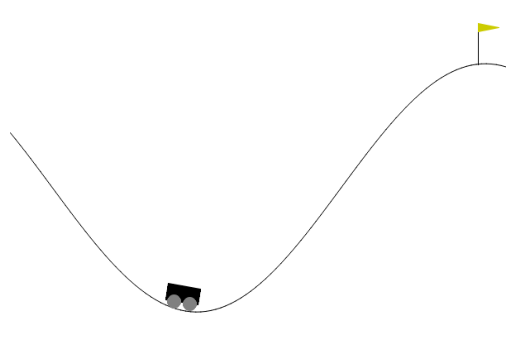

In [5]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

In [22]:
print(env.observation_space, env.action_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Discrete(3)


In [7]:
def discretize(interval, number_batches = -1, batch_percentage = 0.1):

    sum = abs(interval[0]) + abs(interval[1])

    if number_batches != -1:
        batch_size = sum/number_batches
    else:
        batch_size = batch_percentage*sum

    return np.arange(interval[0], interval[1], batch_size)

- P -> Number of discrete positions
- V -> Number of discrete velocities

In [29]:
# TODO in the end, put all "global" parameters in one cell for easier manipulation ???

In [32]:
BATCH_PERC = 0.025

position_batches = discretize((env.observation_space.low[0],env.observation_space.high[0]), batch_percentage=BATCH_PERC)
P = len(position_batches)

velocity_batches = discretize((env.observation_space.low[1],env.observation_space.high[1]), batch_percentage=BATCH_PERC)
V = len(velocity_batches)

print(P, position_batches)
print(V, velocity_batches)

40 [-1.20000005 -1.15500005 -1.11000004 -1.06500004 -1.02000004 -0.97500004
 -0.93000004 -0.88500004 -0.84000003 -0.79500003 -0.75000003 -0.70500003
 -0.66000003 -0.61500002 -0.57000002 -0.52500002 -0.48000002 -0.43500002
 -0.39000002 -0.34500001 -0.30000001 -0.25500001 -0.21000001 -0.16500001
 -0.12       -0.075      -0.03        0.015       0.06        0.105
  0.15000001  0.19500001  0.24000001  0.28500001  0.33000001  0.37500001
  0.42000002  0.46500002  0.51000002  0.55500002]
40 [-7.00000003e-02 -6.65000003e-02 -6.30000003e-02 -5.95000003e-02
 -5.60000002e-02 -5.25000002e-02 -4.90000002e-02 -4.55000002e-02
 -4.20000002e-02 -3.85000002e-02 -3.50000001e-02 -3.15000001e-02
 -2.80000001e-02 -2.45000001e-02 -2.10000001e-02 -1.75000001e-02
 -1.40000001e-02 -1.05000000e-02 -7.00000003e-03 -3.50000001e-03
  1.11022302e-16  3.50000001e-03  7.00000003e-03  1.05000000e-02
  1.40000001e-02  1.75000001e-02  2.10000001e-02  2.45000001e-02
  2.80000001e-02  3.15000001e-02  3.50000001e-02  3.8500

In [33]:
def get_index_position_batch(position):

    l = len(position_batches)

    for low in range(l):
        
        if position < position_batches[low]:
            return low-1

    return l-1

def get_index_velocity_batch(velocity):

    l = len(position_batches)
    
    for low in range(l):
        
        if velocity < position_batches[low]:
            return low-1

    return l-1

In [34]:
q_table = np.zeros((P, V, env.action_space.n))
print(q_table.shape)

(40, 40, 3)


In [35]:
def epsilon_greedy(state, epsilon):
    global q_table
    
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        # assuming state is a tuple with (position, velocity)
        return np.argmax(q_table[state[0], state[1], :])

In [50]:
#hyper-parameters
alpha = 0.8 #learning rate
gamma = 0.95
epsilon = 0.1
num_episodes = 10001
num_steps = 1000

In [51]:
#for each episode:
arr_total_rewards = []
arr_steps = []
arr_done = np.zeros(num_episodes)

for i in range(num_episodes):

    #initialize the state by resetting the environment
    s,_ = env.reset()
    total_reward = 0
    steps = 0

    # discretize
    s = [get_index_position_batch(s[0]), get_index_velocity_batch(s[1])]

    #for each step in the episode
    for t in range(num_steps):

        #select the action using the epsilon-greedy policy
        a = epsilon_greedy(s,epsilon)

        #perform the selected action and store the next state information
        s_, r, done, _, _ = env.step(a)

        # discretize
        s_ = [get_index_position_batch(s_[0]), get_index_velocity_batch(s_[1])]

        #first, select the action a dash which has a maximum Q value in the next state
        v_opt = np.argmax(q_table[s_[0], s_[1], :])
        
        # we calculate the Q value of previous state using our update rule
        q_table[s[0], s[1], a] = q_table[s[0], s[1], a] + alpha * (r + gamma * (v_opt) - q_table[s[0], s[1], a])
        
        #update current state to next state
        s = s_

        #info
        total_reward += r
        steps += 1

        #if the current state is the terminal state then break
        if done:
            steps = t
            arr_done[i] = 1
            break

    arr_total_rewards.append(total_reward)
    arr_steps.append(steps)

    if(i%1000 == 0):
        print(f"Episode {i} | Total Reward {total_reward} | Steps {steps}")

Episode 0 | Total Reward -1000.0 | Steps 1000
Episode 1000 | Total Reward -1000.0 | Steps 1000
Episode 2000 | Total Reward -1000.0 | Steps 1000
Episode 3000 | Total Reward -1000.0 | Steps 1000
Episode 4000 | Total Reward -1000.0 | Steps 1000
Episode 5000 | Total Reward -1000.0 | Steps 1000
Episode 6000 | Total Reward -1000.0 | Steps 1000
Episode 7000 | Total Reward -1000.0 | Steps 1000
Episode 8000 | Total Reward -1000.0 | Steps 1000
Episode 9000 | Total Reward -1000.0 | Steps 1000
Episode 10000 | Total Reward -1000.0 | Steps 1000


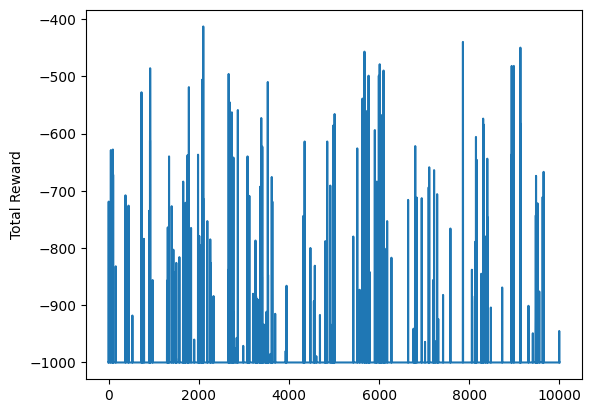

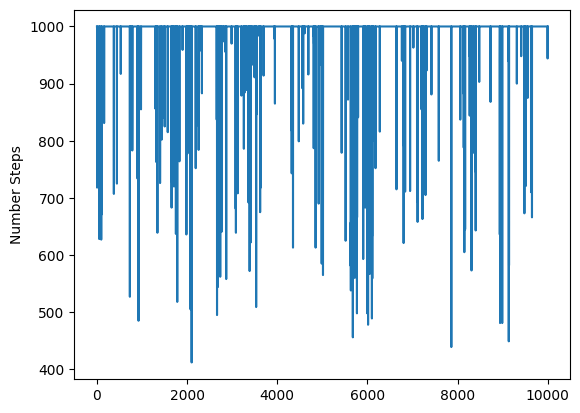

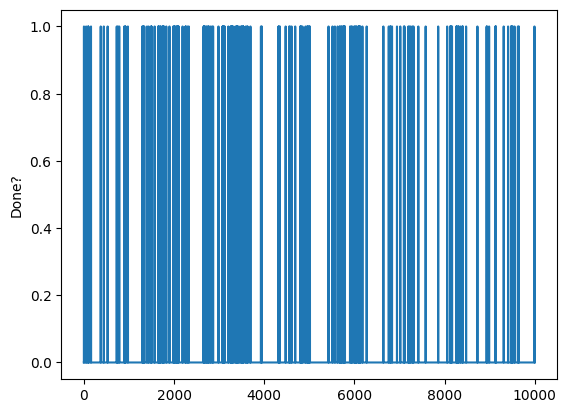

In [52]:
plt.ylabel("Total Reward")
plt.plot(range(0,num_episodes),arr_total_rewards)
plt.show()

plt.ylabel("Number Steps")
plt.plot(range(0,num_episodes),arr_steps)
plt.show()

plt.ylabel("Done?")
plt.plot(range(0,num_episodes),arr_done)
plt.show()

In [53]:
# Get the optimal policy
# print(q_table)
optimal_policy = np.zeros((P,V))
for pos in range(P):
    for vel in range(V):
        optimal_policy[pos,vel] = np.argmax(q_table[pos, vel, :])

print(optimal_policy)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 2. Deep-Q Learning